In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchsummary import summary
import tensorflow as tf
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

import os
import sys

# Depth Image Dataset

In [10]:
load_path = "../../../rl_data/tfrecord"

In [11]:
sys.path.append('.')

def get_files_ending_with(folder_or_folders, ext):
    if isinstance(folder_or_folders, str):
        folder = folder_or_folders
        assert os.path.exists(folder)

        fnames = []
        for fname in os.listdir(folder):
            if fname.endswith(ext):       
                fnames.append(os.path.join(folder, fname))
        return sorted(fnames)
    else:
        assert hasattr(folder_or_folders, '__iter__')
        print('folder_or_folders:', folder_or_folders)
        return list(itertools.chain(*[get_files_ending_with(folder, ext) for folder in folder_or_folders]))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def collate_batch(batch):
    # image, actions, robot_state, collision_label, info_label, height, width, depth, action_horizon = [], [], [], [], [], [], [], [], []
    # for _image, _actions, _robot_state, _collision_label, _info_label, _height, _width, _depth, _action_horizon in batch:
    #     image.append(_image.numpy())
    #     actions.append(_actions.numpy())
    #     robot_state.append(_robot_state.numpy())
    #     collision_label.append(_collision_label.numpy())
    #     info_label.append(_info_label.numpy())
    #     height.append(_height.numpy())
    #     width.append(_width.numpy())
    #     depth.append(_depth.numpy())
    #     action_horizon.append(_action_horizon.numpy())
    # print('batch[0]:', batch[0])
    image = batch[0][0]
    height = batch[0][1]
    width = batch[0][2]
    depth = batch[0][3]
    
    return torch.Tensor(np.array(image)).to(device), torch.Tensor(np.array(height)).to(device), torch.Tensor(np.array(width)).to(device), torch.Tensor(np.array(depth)).to(device)


class DepthImageDataset(torch.utils.data.IterableDataset):
    def __init__(self, tfrecord_folder, batch_size=32, shuffle=True):
        super(DepthImageDataset).__init__()
        self.tfrecord_folder = tfrecord_folder
        self.dataset, self.data_len = self.load_tfrecords(is_shuffle_and_repeat=shuffle, batch_size=batch_size)

    def read_tfrecord(self, serialized_example):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
        }
        example = tf.io.parse_single_example(serialized_example, feature_description)

        image = tf.transpose(tf.cast(tf.io.parse_tensor(example['image'], out_type = tf.uint8), tf.float32),  perm=[2, 0, 1]) / 256
        height = example['height']
        width = example['width']
        depth = example['depth']
        return image, height, width, depth

    def load_tfrecords(self, is_shuffle_and_repeat=True, shuffle_buffer_size=5000, prefetch_buffer_size_multiplier=2, batch_size=32):
        print('Loading tfrecords...')
        tfrecord_fnames = get_files_ending_with(self.tfrecord_folder, '.tfrecords')
        assert len(tfrecord_fnames) > 0
        if is_shuffle_and_repeat:
            np.random.shuffle(tfrecord_fnames)
        else:
            tfrecord_fnames = sorted(tfrecord_fnames) # 176 tfrecords for train, 20 for test

        tfrecord_fnames = tfrecord_fnames[:1]
        print(tfrecord_fnames)

        dataset = tf.data.TFRecordDataset(tfrecord_fnames)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if is_shuffle_and_repeat: 
            dataset = dataset.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=prefetch_buffer_size_multiplier * batch_size)

        print('Iterating length...')
        data_len = sum(1 for _ in dataset)
        print('Done.')
        
        return dataset, data_len
    
    def __iter__(self):
        print("gotcha")
        return self.dataset.__iter__()

    def __len__(self):
        return self.data_len


In [12]:
dataset = DepthImageDataset(load_path)

Loading tfrecords...
['../../../rl_data/tfrecord/data86.tfrecords']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Iterating length...
Done.


# Dataloader

In [13]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_batch)
image, *_ = next(iter(data_loader))

gotcha


In [14]:
len(dataset), len(data_loader)

(67, 67)

# Model

In [15]:
from vae_dronet import VAE

In [53]:
vae_model = VAE(n_z=64)

load_model = True

pth = "/home/patricknit/vae_models/vae_dronet_sigmoid_mse_riga_924.pth"
pth2 = "/home/patricknit/vae_models/vae_dronet_sigmoid_mse_riga_209.pth"

if load_model:
    vae_model.load_state_dict(torch.load(pth2))
    vae_model.eval()
else:
    vae_model.train()


[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model


# Test

gotcha
torch.Size([32, 1, 270, 480])
torch.Size([1, 270, 480])


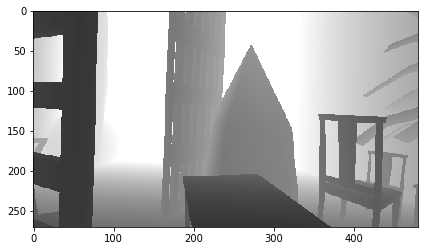

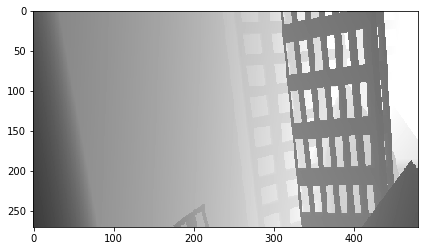

In [23]:
dataiter = iter(data_loader)
images, *_ = dataiter.next()
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

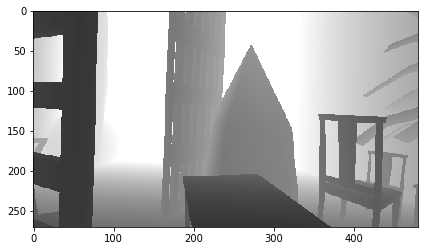

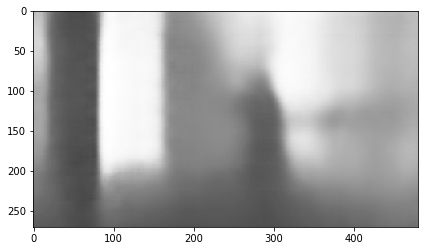

In [55]:
vae_model.eval()
with torch.no_grad():
    img_recon, means, logvar, z = vae_model(images)

idx = 1
imshow(images[idx])
imshow(img_recon[idx])

# Weights

y1 : 6.494522094726562e-05, y2 : 3.1614303588867186e-05, y3 : 5.745887756347657e-06


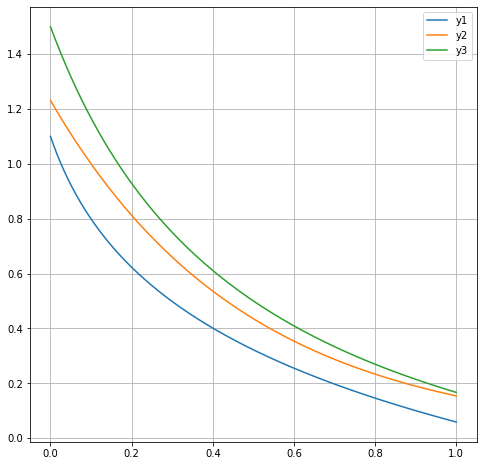

In [142]:
def depth_func1(x):
    return -np.log10(x+0.1) + 0.1

def depth_func1(x):
    return np.exp(-3*(x-0.1))

def depth_func2(x):
    return 2**(-3*(x-0.1))

def depth_func3(x):
    return 1/(x+.5) - .5

import time
x = np.arange(0, 1.001, 0.001)
t1 = []
t2 = []
t3 = []
for i in range(10):
    st = time.time()
    y1 = depth_func1(x)
    end1 = time.time()
    y2 = depth_func2(x)
    end2 = time.time()
    y3 = depth_func3(x)
    end3 = time.time()
    t1.append(end1 - st)
    t2.append(end2 - end1)
    t3.append(end3 - end2)
    
print(f"y1 : {np.array(t1).mean()}, y2 : {np.array(t2).mean()}, y3 : {np.array(t3).mean()}")

plt.figure(figsize=(8, 8))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.grid()
plt.legend(["y1", "y2", "y3"])
plt.show()

# Check

In [149]:
def mse_loss(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss + kl_divergence, kl_divergence, reproduction_loss

def mse_loss2(x, x_hat, mu, logvar):
    reproduction_loss = (depth_func3(x) * (x_hat - x)**2).sum() 
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss + kl_divergence, kl_divergence, reproduction_loss

In [150]:
mse_loss(images, img_recon, means, logvar)

(tensor(39530.2969), tensor(3184.5581), tensor(36345.7383))

In [151]:
mse_loss2(images, img_recon, means, logvar)

(tensor(20154.6289), tensor(3184.5581), tensor(16970.0703))